# Lekce 12

In [16]:
import pandas
import requests

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score,
)

## Co to je NLP
Práce s přirozeným jazykem je odlišná od práce s jinými daty, a proto si zaslouží vlastní skupinu technik a algoritmů - NLP (Natural Language Processing). Ne všechny úlohy NLP se musí řešit pomocí strojového učení, ale v dnešní době tomu tak většinou je. Příklady úloh, které spadají do NLP jsou například:

- Strojový překlad (text v angličtině => text v češtině)
- Rozpoznávání řeči (řeč v češtině => text v češtině)
- Syntéza řeči (text v češtině > řeč v češtině)
- Klasifikace textu

Tyto úlohy určitě znáte i z běžného života. Další úlohy, které řeší NLP, a nacházejí se často "pod kapotou" jiných systémů, jsou například:

- Rozpoznávání pojmenovaných entit (NER, Named Entity Recognition): Pojmenované entity jsou výrazy, které označují jména, místa, data, názvy, ... Jaké pojmenované entity bychom mohli označit například ve větě _Král Karel si v Londýně včera zašel do kavárny Starbucks._ ?
- Určování slovních druhů (POS tagging, Part-of-speech tagging)
- Zjednodušení textu, shrnutí textu
- Určení významu slova (WSD, Word Sense Disambiguation): Při dvou významech slova _kolej_ (studentské ubytování, železniční dráha), který z nich je zachycený větou _Včera proběhl na koleji večírek._ ?

### Reprezentace textových dat

Naše datasety doposud obsahovaly proměnné, a datové body (pozorování) reprezentované pomocí těchto proměnných. Například u vzorku vody jsme dostali proměnné na základě chemického rozboru. U textových dat většinou dostaneme syrovější podobu dat, nikoliv proměnné. Jako kdybychom dostali vzorky vody, a sami museli provést chemickou analýzu.

Pojďme si schválně načíst dataset, se kterým budeme dneska pracovat. K dispozici máme název filmu, jeho žánr (to bude naše výstupní proměnná), a text popisku filmu. Text popisku budeme chtít převést na naše vstupní proměnné.


Obecně řečeno, i v případě textu budeme jednotlivá pozorování nebo datové body reprezentovat pomocí číselných hodnot vstupních proměnných. Co ale budou tyto proměnné, označené v obrázku jako barvy, reprezentovat?

In [32]:
X = ["Python is great", "I like Python", "Python is the best language"]
vec = CountVectorizer()
X = vec.fit_transform(X)
X.toarray()

array([[0, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 1, 0],
       [1, 0, 1, 1, 0, 1, 1]], dtype=int64)

In [33]:
vec.get_feature_names_out()

array(['best', 'great', 'is', 'language', 'like', 'python', 'the'],
      dtype=object)

In [ ]:
data = pandas.read_csv("movies.csv")
data

In [18]:
X = data["text"]
y = data["genre"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

Musíme myslet na to, že rozložení jednotlivých skupin je velmi nerovnoměrné.

<Axes: xlabel='genre'>

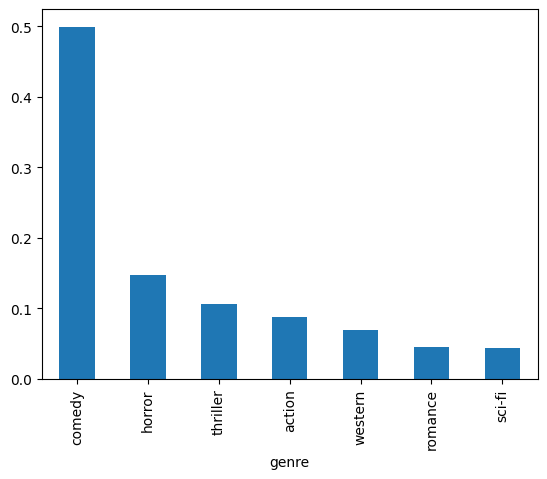

In [19]:
y_train.value_counts(normalize=True).plot(kind="bar")

Jako první formu reprezentace popisků vyzkoušíme jednotlivá slova a jejich počty. V podstatě vytvoříme slovní zásobu, která bude obsahovat všechna slova, co se v našich trénovacích datech objeví. Jedno slovo bude jedna proměnná a hodnota proměnné bude počet, kolikrát se slovo v dokumentu (zde popisku filmu) objeví.

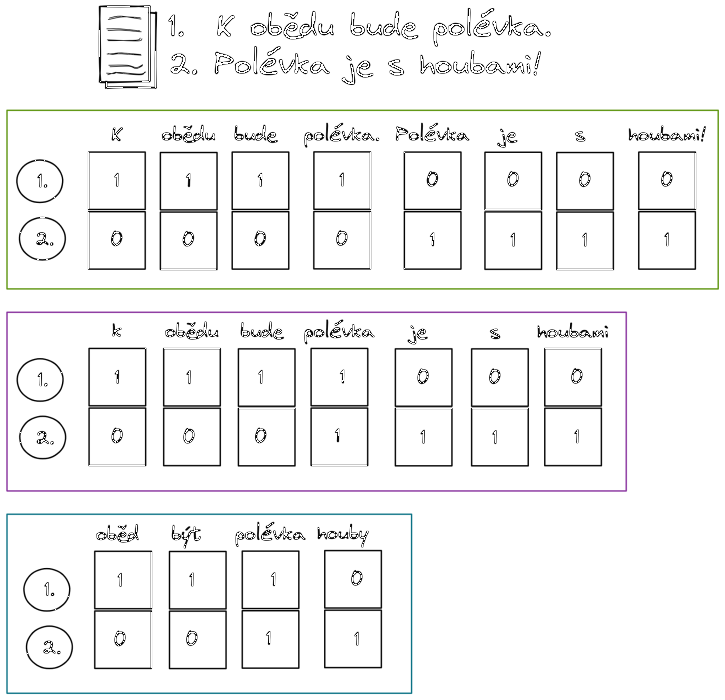

Pomůžeme si třídou `CountVectorizer` z balíčku `scikit-learn`.

In [20]:
vec = CountVectorizer()
X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

Jak teď naše data vypadají?

In [26]:
X_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [27]:
vec.get_feature_names_out()

array(['00', '000', '003', ..., 'ťthe', 'źs', 'žš'], dtype=object)

Pojďme zkusit tyto vstupní proměnné předat klasifikačnímu algoritmu.

In [22]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

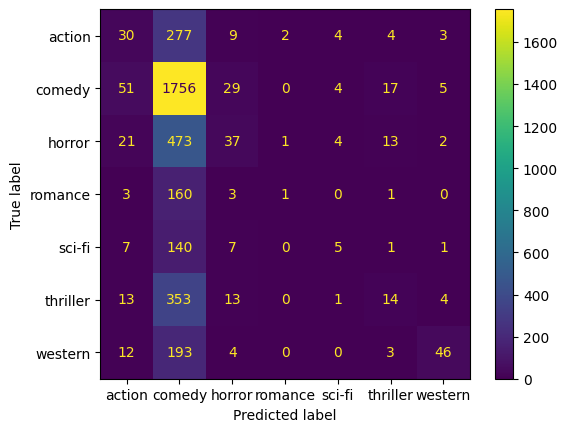

In [23]:
ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test,
    y_test,
)

In [24]:
accuracy_score(y_test, y_pred)

0.5068419640461497

Jak můžeme úspěšnost modelu zlepšit? V podstatě jsou dvě úrovně: Úroveň dat, a úroveň klasifikačního algoritmu. Pojďme začít u dat, protože když nebudeme mít čistá data, žádný algoritmus nás nezachrání (toto se dá také shrnout pořekadlem "garbage in, garbage out").
- Všimněme si, že nejčastější slova jsou taková, která se nacházejí skoro ve všech popiskách. Těmto častým slovům, která nenesou žádný význam, se říka _stop words_. Každý jazyk má svůj blacklist těchto slov, která se většinou z dat úplně vyfiltrují. `CountVectorizer` má parametr `stop_words`, který můžeme nastavit na hodnotu `"english"`. 

- Dále se zamysleme nad tím, co znamenají hodnoty našich vstupních proměnných. Možná by bylo lepší tyto hodnoty nějak normalizovat ( co kdybychom například měli veliké rozdíly mezi délkou vstupních dokumentů?). Populární metoda pro normalizaci četností slov je TF-IDF. Tato normalizace zohledňuje jak četnost slova v dokumentu, tak i to, jak často se objevuje vůbec v celých vstupních datech. Takže slovo, které by se velmi často objevovalo jen v několika dokumentech, by mělo větší váhu, než jiné slovo, které se objevuje v mnoha dokumentech, s malým zastoupením. 

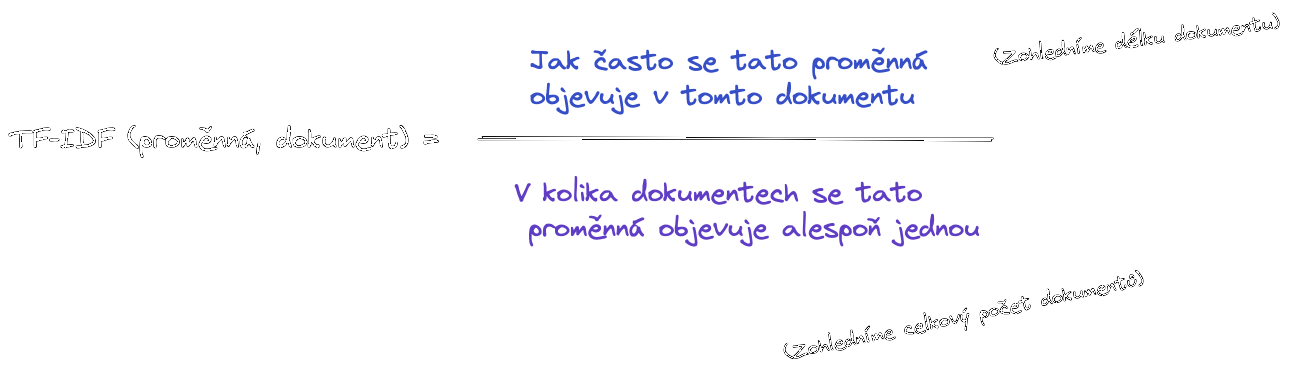

Můžeme tedy `CountVectorizer` vyměnit za `TfidfVectorizer`. Jak moc je teď důležitý parametr `stop_words`?

In [34]:
X = ["Python is great", "I like Python", "Python is the best language"]
vec = TfidfVectorizer()
X = vec.fit_transform(X)
X.toarray()

array([[0.        , 0.72033345, 0.54783215, 0.        , 0.        ,
        0.42544054, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.861037  ,
        0.50854232, 0.        ],
       [0.50461134, 0.        , 0.38376993, 0.50461134, 0.        ,
        0.29803159, 0.50461134]])

In [35]:
vec.get_feature_names_out()

array(['best', 'great', 'is', 'language', 'like', 'python', 'the'],
      dtype=object)

In [36]:
X = [
    "Python is great", 
    "I like Python", 
    "Python is the best language"
    ]
vec = TfidfVectorizer(stop_words="english")
X = vec.fit_transform(X)
X.toarray()

array([[0.        , 0.861037  , 0.        , 0.        , 0.50854232],
       [0.        , 0.        , 0.        , 0.861037  , 0.50854232],
       [0.65249088, 0.        , 0.65249088, 0.        , 0.38537163]])

In [37]:
vec.get_feature_names_out()

array(['best', 'great', 'language', 'like', 'python'], dtype=object)

### Čtení na doma

In [76]:
X = [
    "Python is great", 
    "I like Python", 
    "Python is the best language"
    ]

vec = CountVectorizer(stop_words="english")
X = vec.fit_transform(X)
X.toarray()

array([[0, 1, 0, 0, 1],
       [0, 0, 0, 1, 1],
       [1, 0, 1, 0, 1]], dtype=int64)

In [86]:
X = [
    "Python is great", 
    "I like Python", 
    "Python is the best language"
    ]

vec = TfidfVectorizer(stop_words="english", smooth_idf=False)
X = vec.fit_transform(X)
X.toarray()

array([[0.        , 0.90275015, 0.        , 0.        , 0.43016528],
       [0.        , 0.        , 0.        , 0.90275015, 0.43016528],
       [0.67009179, 0.        , 0.67009179, 0.        , 0.31930233]])

In [68]:
vec.get_feature_names_out()

array(['best', 'great', 'language', 'like', 'python'], dtype=object)

In [78]:
import numpy

n = 3
df_great = 1
idf_great = numpy.log(n / df_great) + 1
idf_great

2.09861228866811

In [79]:
tf_idf_great = 1 * idf_great
tf_idf_great

2.09861228866811

In [80]:
df_python = 3
idf_python = numpy.log(n / df_python) + 1
idf_python

1.0

In [81]:
tf_idf_python = 1 * idf_python
tf_idf_python

1.0

In [84]:
tf_idf_great / numpy.sqrt(tf_idf_great ** 2 + tf_idf_python ** 2)

0.9027501480103624

In [90]:
X = [
    "Python is great", 
    "I like Python", 
    "Python is the best language"
    ]

vec = TfidfVectorizer(stop_words="english")
X = vec.fit_transform(X)
X.toarray()

array([[0.        , 0.861037  , 0.        , 0.        , 0.50854232],
       [0.        , 0.        , 0.        , 0.861037  , 0.50854232],
       [0.65249088, 0.        , 0.65249088, 0.        , 0.38537163]])

In [92]:
n = 3
df_great = 1
idf_great = numpy.log((1 + n) / (1 + df_great)) + 1
tf_idf_great = 1 * idf_great
df_python = 3
idf_python = numpy.log((1 + n) / (1 + df_python)) + 1
tf_idf_python = 1 * idf_python
tf_idf_great / numpy.sqrt(tf_idf_great ** 2 + tf_idf_python ** 2)

0.8610369959439764

### Vlastní seznam stop words

In [40]:
X = [
    "Python je nejlepší", 
    "Mám rád Python!", 
    "Python je nejlepší jazyk"
    ]
vec = TfidfVectorizer(stop_words=["je", "mám"])
X = vec.fit_transform(X)
X.toarray()

array([[0.        , 0.78980693, 0.61335554, 0.        ],
       [0.        , 0.        , 0.50854232, 0.861037  ],
       [0.72033345, 0.54783215, 0.42544054, 0.        ]])

In [41]:
vec.get_feature_names_out()

array(['jazyk', 'nejlepší', 'python', 'rád'], dtype=object)

In [28]:
X = data["text"]
y = data["genre"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

vec = TfidfVectorizer()
X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.5709686074590824

In [29]:
X = data["text"]
y = data["genre"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

vec = TfidfVectorizer(stop_words="english")
X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.5811644754494232

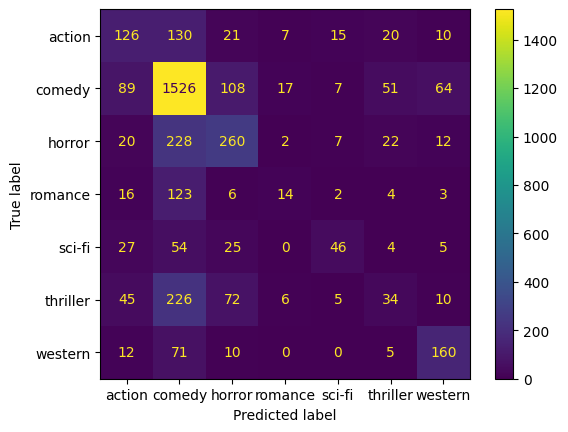

In [30]:
ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test,
    y_test,
)

In [93]:
X = data["text"]
y = data["genre"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

vec = TfidfVectorizer(stop_words="english", ngram_range=(1, 2))
X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.594311778910652

In [107]:
X = data["text"]
y = data["genre"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

vec = TfidfVectorizer(stop_words="english", ngram_range=(1, 2))
X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

clf = LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.7646900992755568

In [108]:
clf.classes_

array(['action', 'comedy', 'horror', 'romance', 'sci-fi', 'thriller',
       'western'], dtype=object)

In [120]:
df_coef = pandas.DataFrame(clf.coef_.T, columns=clf.classes_)
df_coef["words"] = vec.get_feature_names_out()
df_coef = df_coef.set_index("words")
df_coef

,action,comedy,horror,romance,sci-fi,thriller,western
words,,,,,,,
00,-0.099350,0.130305,0.120463,-0.015071,-0.026517,-0.073392,-1.879415e-02
00 31,-0.012009,-0.115527,0.140133,0.000000,-0.014201,0.000000,1.951564e-18
00 bonus,-0.001865,0.017467,0.000000,-0.003824,0.000000,-0.009323,-3.264278e-03
00 breast,-0.001865,0.017467,0.000000,-0.003824,0.000000,-0.009323,-3.264278e-03
00 cameraman,-0.000086,-0.094925,0.120942,0.000000,-0.004197,-0.019086,0.000000e+00
...,...,...,...,...,...,...,...
źs,-0.037891,0.166505,-0.055953,-0.003899,-0.018278,-0.033222,0.000000e+00
źs 70,-0.018945,0.083252,-0.027976,-0.001949,-0.009139,-0.016611,0.000000e+00
źs sit,-0.018945,0.083252,-0.027976,-0.001949,-0.009139,-0.016611,0.000000e+00


In [122]:
df_coef.sort_values("sci-fi", ascending=False).head(20)

,action,comedy,horror,romance,sci-fi,thriller,western
words,,,,,,,
earth,-0.294947,-1.237952,-0.801129,-0.268356,3.309363,-0.806988,-0.353077
alien,-0.566869,-1.197390,-0.757693,-0.077991,2.773563,-0.334576,-0.112049
space,-0.768361,-0.964673,-0.311594,-0.133082,2.477230,-0.393162,-0.192474
planet,0.009480,-1.036256,-0.557428,-0.187358,2.372878,-0.624937,-0.270642
future,0.057930,-1.028436,-0.682450,0.173209,1.988740,-0.305909,-0.325943
scientist,-0.221591,-0.927773,0.184160,-0.110859,1.536081,-0.304290,-0.161322
humans,0.000865,-0.684499,-0.462961,-0.162125,1.530960,-0.128611,-0.097184
fi,-0.249849,-0.797507,-0.137050,0.016366,1.432206,-0.296493,-0.099476
universe,0.071515,-0.684298,-0.239304,-0.069726,1.418393,-0.461758,-0.137468


In [123]:
df_coef.sort_values("sci-fi", ascending=False).tail(20)

,action,comedy,horror,romance,sci-fi,thriller,western
words,,,,,,,
vampire,-0.688379,-1.086779,2.751205e+00,-0.093724,-0.378506,-0.610544,-0.218636
better,0.005629,0.972702,3.994887e-02,-0.250133,-0.378782,-0.404199,-0.107159
face,0.235859,-0.703110,3.111223e-01,0.189370,-0.382372,0.272669,-0.020216
brother,0.345755,-0.950423,1.536625e-01,0.079176,-0.383114,0.112089,0.684898
gets,-0.137309,0.532384,-8.516061e-01,0.097244,-0.389205,0.335903,0.259116
house,-1.068139,-0.657863,2.113204e+00,-0.307470,-0.395765,0.115148,-0.808792
girlfriend,-0.256424,0.870455,4.793748e-02,-0.116427,-0.411818,0.034272,-0.454765
decide,-0.180514,0.739059,2.284445e-01,-0.032534,-0.427470,-0.425363,-0.201886
orbot,0.368715,0.000000,-2.168404e-19,0.000000,-0.436092,0.000000,0.000000
